In [ ]:
# install and load packages
! pip install patool
! pip install pyunpack
! pip install textdistance

import argparse
import os
import random
import requests
import zipfile
import errno
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyunpack import Archive
import string
from PIL import Image
from tqdm import tqdm
import torch.nn.functional 
from sklearn.metrics import accuracy_score
from textdistance import ratcliff_obershelp


     |████████████████████████████████| 77 kB 2.3 MB/s 


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()

print(f'We are now using {device}. There are {n_cudas} available gpus.')

if torch.cuda.is_available():
    print(f'{torch.cuda.get_device_name(0)}')

We are now using cuda. There are 1 available gpus.
Tesla K80


In [ ]:
# setup

folder = 'demo'     # name of folder in archive
captcha_len = 6     # number of symbols in captcha 

# Load data

In [ ]:
# load demo data
# available at https://drive.google.com/file/d/1eVSu90LUS-y6Srx1iNXLx7PodoHO75rR or at GitHub subfolder 'samples'

!gdown --id 1eVSu90LUS-y6Srx1iNXLx7PodoHO75rR


Downloading...
From: https://drive.google.com/uc?id=1eVSu90LUS-y6Srx1iNXLx7PodoHO75rR
To: /content/captcha_demo.tar.gz
100% 18.8M/18.8M [00:00<00:00, 48.4MB/s]


In [ ]:
# create folders to unzip data
! mkdir '{folder}'

# unzip data
Archive('captcha_{}.tar.gz'.format(folder)).extractall(folder)

# check number of files
labels = os.listdir('{}/{}'.format(folder,folder))
print('{} files:'.format(folder), len(labels))

demo files: 2000


# Create dataloaders

In [ ]:
workers = 2                           # worker threads for loading the data with the DataLoader
batch_size = 256                      # size of batch
image_size = [60, 180]                # size of imput images
nc = 3                                # number of color channels in the input images

# normalization parameters
normalize_mean = (0.485, 0.456, 0.406)
normalize_std = (0.229, 0.224, 0.225)

# for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
# define dataset
class Custom_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data_dir, data_labels):
        self.data_dir = data_dir
        self.data_labels = data_labels
        
    def __len__(self):
        return len(self.data_labels)
    
    def __getitem__(self, index):
        image_label = self.data_labels[index]
        image_fp = os.path.join(self.data_dir, image_label)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_label.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ])
        return transform_ops(image)

In [ ]:
# create dataloaders
dataset = Custom_Dataset('{}/{}'.format(folder,folder), labels) 
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=workers, shuffle=True)
print('loader length: ', len(loader))

loader length:  8


In [ ]:
# decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def UnNormalizeBatch(batch):
    for i in range(batch.shape[3]):
       batch[:,:,:,i] = (batch[:,:,:,i] * normalize_std[i]) + normalize_mean[i]

    return batch

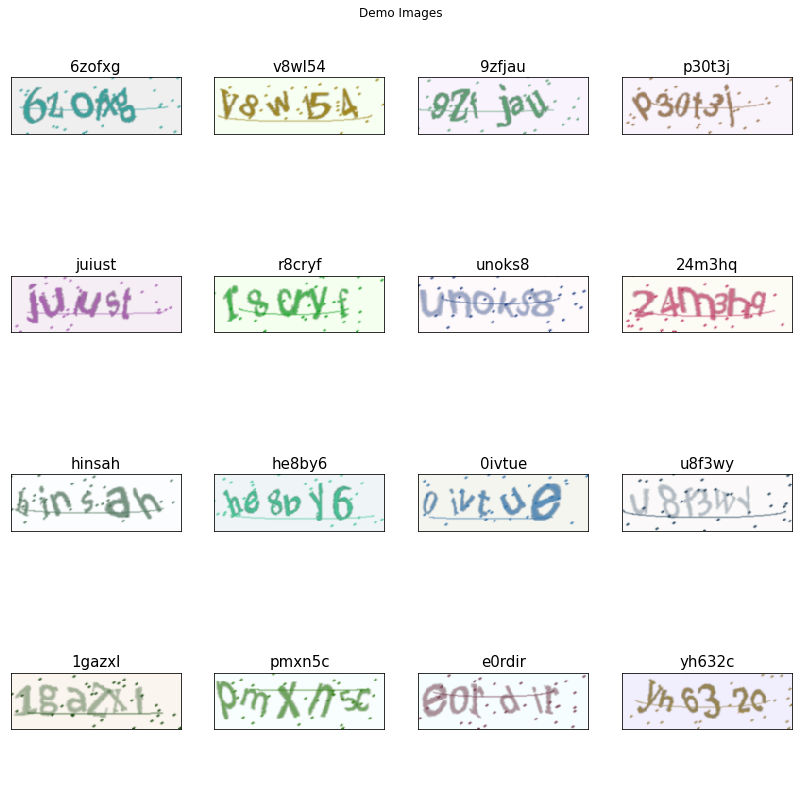

In [ ]:
# view some images
real_batch = next(iter(loader))
real_batch_pictures = np.transpose(real_batch[0].to(device).cpu().detach().numpy(),(0,2,3,1))
real_batch_pictures = UnNormalizeBatch(real_batch_pictures)

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Demo Images")

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(real_batch_pictures[i], interpolation='nearest')
    plt.title(real_batch[1][i], color='k', fontsize=15)

# Load model

In [ ]:
# define model
rnn_hidden_size = 256
symbols = string.ascii_uppercase + string.ascii_lowercase + string.digits
num_symbols = len(symbols)
symbols_char = {k:v for k,v in enumerate(symbols, start=0)}
symbols_idx = {v:k for k,v in symbols_char.items()}

resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

class CTC(nn.Module):
    
    def __init__(self, num_symbols, rnn_hidden_size=256, dropout=0.1):
        
        super(CTC, self).__init__()
        self.num_chars = num_symbols
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2 - for resnet18
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)

        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_symbols)
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# define loss
criterion = nn.CTCLoss(blank=0)

def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [symbols_idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = torch.nn.functional.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [ ]:
# load model

# # v1 - accuracy 79.3 %
# # available at https://drive.google.com/file/d/1BbHKNkIdQxAg1fKLic_FtjZXfmHR20Gk or at GitHub subfolder 'models'
# !gdown --id 1BbHKNkIdQxAg1fKLic_FtjZXfmHR20Gk
# PATH = 'model_final_2.pt'

# # v2 - accuracy 87.9 %
# # available at https://drive.google.com/file/d/1CH9CNbeZnIiR5ZM1GJhkVx6SkxiSQJPG or at GitHub subfolder 'models'
# !gdown --id 1CH9CNbeZnIiR5ZM1GJhkVx6SkxiSQJPG
# PATH = 'model_final_6.pt'

# v3 - accuracy 90.6 %
# available at https://drive.google.com/file/d/1r7zBN8HXCB_1V7zo-uc1QQyh4xXr_17i or at GitHub subfolder 'models'
!gdown --id 1r7zBN8HXCB_1V7zo-uc1QQyh4xXr_17i
PATH = 'model_final_7.pt'


ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

# adjust for gpu or cpu
if torch.cuda.is_available():
    ctc.load_state_dict(torch.load(PATH))
else:
    ctc.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

Downloading...
From: https://drive.google.com/uc?id=1r7zBN8HXCB_1V7zo-uc1QQyh4xXr_17i
To: /content/model_final_7.pt
100% 23.4M/23.4M [00:00<00:00, 109MB/s] 


# Make predictions

In [ ]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = torch.nn.functional.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [symbols_char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
results = pd.DataFrame(columns=['actual', 'prediction'])
# train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(loader, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results = pd.concat([results, df])
results = results.reset_index(drop=True)

100%|██████████| 8/8 [00:03<00:00,  2.38it/s]


In [ ]:
# correct predictions
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

results['prediction_corrected'] = results['prediction'].apply(correct_prediction)

In [ ]:
train_accuracy = accuracy_score(results['actual'], results['prediction_corrected'])
print('Demo accuracy: ', train_accuracy)

Demo accuracy:  0.906


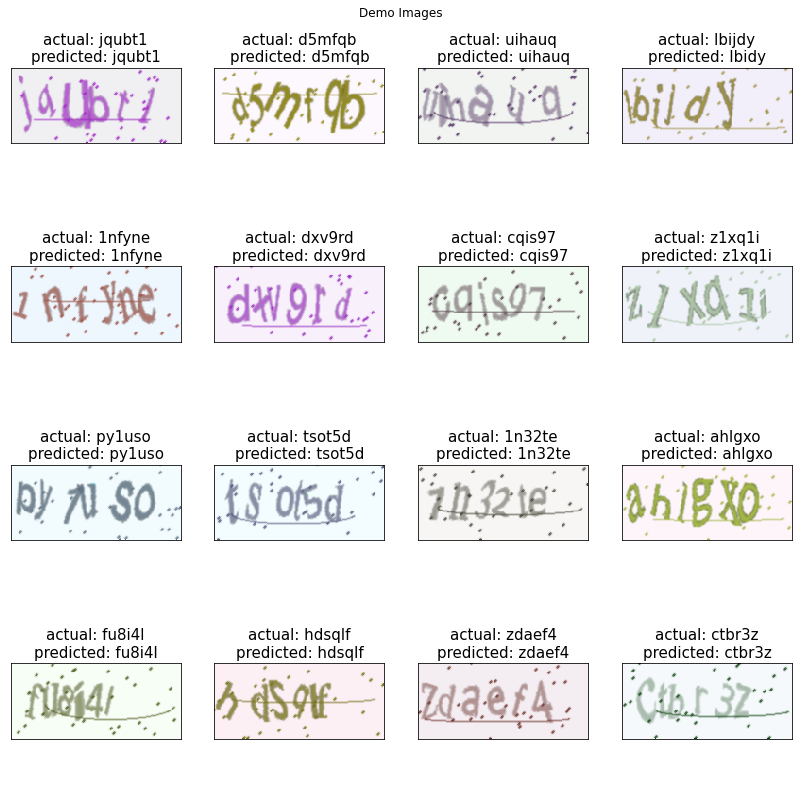

In [ ]:
# view some images and predictions

folder = 'demo'

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Demo Images")

for i in range(16):
    result = results.iloc[i]
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = mpimg.imread('{}/{}/{}.png'.format(folder,folder,result[0]))
    ax.imshow(img, interpolation='nearest')
    plt.title('actual: ' + result[0] + '\n' + 'predicted: ' + result[2], color='k', fontsize=15)

# Robustness of model

check performace for captchas with varying length (3-8 symbols)

In [ ]:
folder = 'demo_2'

# load demo_2 data
# available at https://drive.google.com/file/d/1eIBtOMFPHdzn1EaRFmW8A00Ea9vY7P-Z or at GitHub subfolder 'samples'

!gdown --id 1eIBtOMFPHdzn1EaRFmW8A00Ea9vY7P-Z

# create folders to unzip data
! mkdir '{folder}'

# unzip data
Archive('captcha_{}.tar.gz'.format(folder)).extractall(folder)

labels_2 = os.listdir('{}/{}'.format(folder,folder))

# create dataloaders
dataset_2 = Custom_Dataset('{}/{}'.format(folder,folder), labels_2) 
loader_2 = torch.utils.data.DataLoader(dataset_2, batch_size=batch_size, num_workers=workers, shuffle=True)

results_2 = pd.DataFrame(columns=['actual', 'prediction'])
# train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(loader_2, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_2 = pd.concat([results_2, df])
results_2 = results_2.reset_index(drop=True)

# correct predictions
results_2['prediction_corrected'] = results_2['prediction'].apply(correct_prediction)

Downloading...
From: https://drive.google.com/uc?id=1eIBtOMFPHdzn1EaRFmW8A00Ea9vY7P-Z
To: /content/captcha_demo_2.tar.gz
100% 16.8M/16.8M [00:00<00:00, 101MB/s]


100%|██████████| 8/8 [00:03<00:00,  2.41it/s]


In [ ]:
train_2_accuracy = accuracy_score(results_2['actual'], results_2['prediction_corrected'])
print('Demo_2 accuracy: ', train_2_accuracy)

Demo_2 accuracy:  0.900350525788683


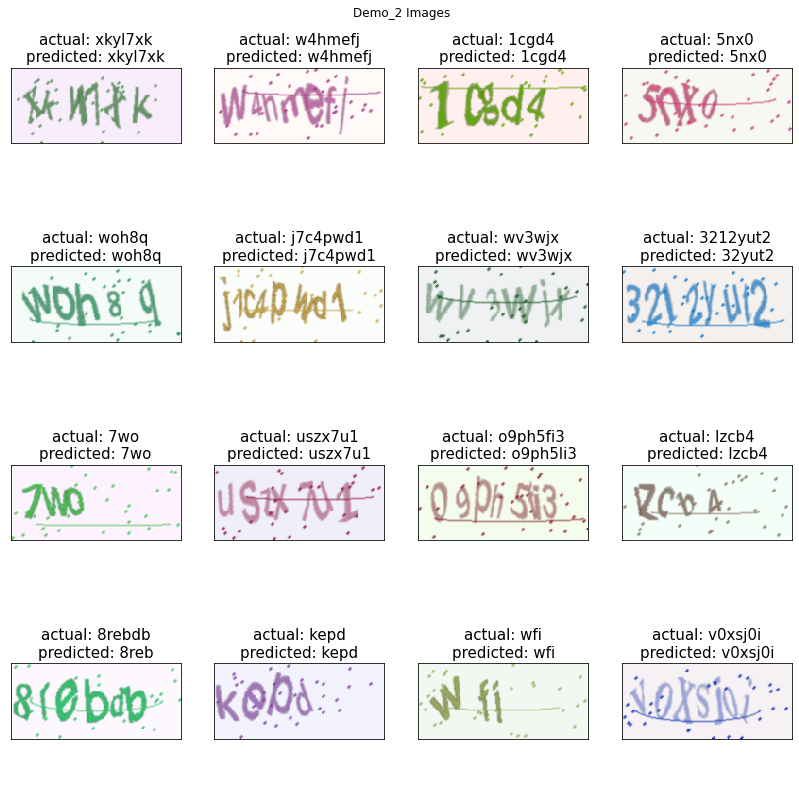

In [ ]:
# view some images and predictions

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Demo_2 Images")

for i in range(16):
    result = results_2.iloc[i]
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = mpimg.imread('{}/{}/{}.png'.format(folder,folder,result[0]))
    ax.imshow(img, interpolation='nearest')
    plt.title('actual: ' + result[0] + '\n' + 'predicted: ' + result[2], color='k', fontsize=15)